In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter, OrderedDict
import Bio.PDB.Polypeptide as pp
from os.path import join
import os
from main_functions import *

In [2]:
DATA = 'data/'

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Functional Data

In [4]:
proteins = ['1be9', '1d5r', '1nd4', '3dqw', '4bz3']
protein_names = ['PSD95', 'PTEN', 'APH(3\')II', 'Src CD', 'VIM-2']
measures = ['nodes', 'edges', 'weight', 'distance']

In [5]:
functional_data = dict()
for protein in proteins:
    csv_file = join(DATA, f'functional_{protein}.csv')
    functional_data[protein] = pd.read_csv(csv_file, index_col=0, header=0)

### Perturbation Network Data and Related Functions

In [6]:
data_path = join(DATA, 'structure')
thresholds = [round(i, 1) for i in np.linspace(3, 10, 71)]
sample_thresholds = [round(i, 1) for i in np.linspace(3, 10, 8)]

In [7]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [8]:
def set_size(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim

### Precision and Recall vs Position Percentages

Compare precision scores with functional percentage, leaving parameters fixed at [1,1,1,1] and mincount of 2; 
    and recall scores with prediction percentage, leaving functional percentage fixed at 40%, mincount fixed at 2,
    and varying the functional cutoffs from 1 to 2. Considering loss of function predictions. 

In [9]:
# list to save data, values will be (percentage, score, type, protein)
data_pr = []

In [10]:
# Precision and functional percentage
percentage_range = [round(i,2) for i in np.linspace(0.3, 0.7, 41)] # diff funct percentages to test
for i, protein in enumerate(proteins):
    network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[1,1,1,1])
    for percentage in percentage_range:
        funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
        how_many = funct_extremes.intersection(network_extremes)
        score = ToPercentage(how_many, network_extremes)
        data_pr.append((round(percentage*100,0), score, "Precision - FSP", protein_names[i]))

In [11]:
# Recall and functional percentage
for i, protein in enumerate(proteins):
    recall = []
    network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[1,1,1,1])
    for percentage in percentage_range:
        funct_extremes = GetPercentage(percentage, 'lowest', functional_data[protein])
        how_many = funct_extremes.intersection(network_extremes)
        score = ToPercentage(how_many, funct_extremes)
        data_pr.append((round(percentage*100,0), score, "Recall - FSP", protein_names[i]))

In [12]:
# Precision and recall prediction percentage    
cutoffs = [round(i,2) for i in np.linspace(1,2,81)] # cutoffs to use to get diff prediction percentages
for i, protein in enumerate(proteins):
    recall, precision = [], []
    percentages_added = [] # Keep track of percentages to avoid repeats with different scores when rounding
    n = len(functional_data[protein].columns)
    prediction_percentage = []
    funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
    for cutoff in cutoffs:
        network_extremes = GetNetworkExtremes(protein, 2, measure_cutoffs=[cutoff]*4)
        how_many = funct_extremes.intersection(network_extremes)
        percentage = round(ToPercentage(network_extremes, n), 0)
        score_prc = ToPercentage(how_many, network_extremes)
        score_rec = ToPercentage(how_many, funct_extremes)
        if percentage not in percentages_added:
            data_pr.append((percentage, score_prc, "Precision - Prediction Percentage", protein_names[i]))
            data_pr.append((percentage, score_rec, "Recall - Prediction Percentage", protein_names[i]))
            percentages_added.append(percentage)

In [13]:
data_pr = pd.Series(data_pr).drop_duplicates().tolist()

In [14]:
df2 = pd.DataFrame(data_pr, columns=['Percentage', 'Score', 'Type', 'Protein'])

In [15]:
for protein in protein_names:
    pers = df2.loc[(df2['Type']=='Precision - Prediction Percentage') & (df2['Protein']==protein), 
                       'Percentage'].tolist()
    scores = df2.loc[(df2['Type']=='Precision - Prediction Percentage') & (df2['Protein']==protein), 'Score'].tolist()
    pairs = [i for i in zip(pers, scores)]
    pairs.sort()
    pairs = np.array(pairs)
    per_range = np.arange(pairs[0][0], pairs[-1][0])
    # Fill in missing values with linear interpolation
    lin_interp = np.interp(per_range, pairs[:,0], pairs[:,1])
    # Add missing values to dataframe
    for i, percentage in enumerate(per_range):
        if percentage not in pairs:
            df2.loc[len(df2)] = [percentage, lin_interp[i], 'Precision - Prediction Percentage', protein]

In [16]:
for protein in protein_names:
    pers = df2.loc[(df2['Type']=='Recall - Prediction Percentage') & (df2['Protein']==protein), 
                       'Percentage'].tolist()
    scores = df2.loc[(df2['Type']=='Recall - Prediction Percentage') & (df2['Protein']==protein), 'Score'].tolist()
    pairs = [i for i in zip(pers, scores)]
    pairs.sort()
    pairs = np.array(pairs)
    per_range = np.arange(pairs[0][0], pairs[-1][0])
    # Fill in missing values with linear interpolation
    lin_interp = np.interp(per_range, pairs[:,0], pairs[:,1])
    # Add missing values to dataframe
    for i, percentage in enumerate(per_range):
        if percentage not in pairs:
            df2.loc[len(df2)] = [percentage, lin_interp[i], 'Recall - Prediction Percentage', protein]

In [17]:
?sns.FacetGrid

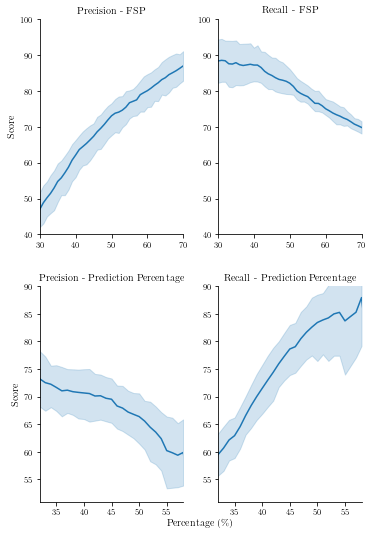

In [18]:
g2 = sns.FacetGrid(data=df2, col="Type", sharex=False, sharey=False, col_wrap=2, height=4, aspect=0.66)
g2.map(sns.lineplot, "Percentage", "Score")
g2.set_titles(row_template = '{row_name}', col_template = '{col_name}')
g2.set_axis_labels("", "Score")
g2.fig.text(0.45,0.04, "Percentage (\%)")

for i, ax in enumerate(g2.axes.flat):
    ax.set_aspect(1)
    if i in [0,1]:
        ax.set_xlim(30,70)
        ax.set_ylim(40,100)
    else:
        ax.set_xlim(32,58)
        ax.set_ylim(51,90)
        ax.set_xticks([35, 40, 45, 50, 55])

plt.subplots_adjust(hspace=-0.2)
plt.tight_layout()
    
g2.savefig('figures/behavior2.png', dpi=300)

### Predictions for single measure

In [19]:
def NetworkExtremesOneMeasure(protein, measure, cutoff, threshold):
    """ Return set with positions that have mutations that pass measure cutoff. """
    network_df = Standardize(protein, threshold, measure)
    extremes = network_df.columns[(network_df > cutoff).any()].tolist()
    return set(extremes)

In [20]:
def dataOneMeasure(cutoff):
    """Loss of function predictions based only on one measure. """
    index = pd.MultiIndex.from_product([proteins, measures, ["Precision", "Recall"]], 
                                       names=["Protein", "Measure", "Score"])
    df = pd.DataFrame(index=index, columns=thresholds)
    
    for j, measure in enumerate(measures):
        for i, protein in enumerate(proteins):
            funct_extremes = GetPercentage(0.4, 'lowest', functional_data[protein])
            
            for threshold in thresholds:
                # positions predicted
                predictions = NetworkExtremesOneMeasure(protein, measure, cutoff, threshold)
                # positions in intersection between predictions and funct_extremes 
                how_many = predictions.intersection(funct_extremes)
                df.at[(protein, measure, "Precision"), threshold] = ToPercentage(how_many, predictions)
                df.at[(protein, measure, "Recall"), threshold] = ToPercentage(how_many, funct_extremes)
    return df

In [21]:
def PredictionsOneMeasure(df):
    """Loss of function predictions based only on one measure, to find best threshold per measure. Takes DataFrame 
    from dataOneMeasure."""
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(17.5,14), sharex=True, sharey=True)
    
    fig.add_subplot(111, frameon=False)
    plt.tight_layout()
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.xlabel('Thresholds')
    fig.text(0, 0.5, "Percentage (\%)", rotation=90)
    
    for j, measure in enumerate(measures):
        for i, protein in enumerate(proteins):
            precision = df.loc[(protein, measure, "Precision"), :].values.tolist()
            recall = df.loc[(protein, measure, "Recall"), :].values.tolist()

            ax = axes[j, i]
            ax.set_xlim(3,10)
            ax.set_ylim(0,100)
            ax.plot(thresholds, precision, color='darkgreen', marker='o', ms=0, markeredgewidth=0.0, linewidth=1,  
                     label='Precision')
            ax.plot(thresholds, recall, color='darkblue', marker='o', ms=0, markeredgewidth=0.0, linewidth=1, 
                     label='Recall')

            if i == 0:
                ax.set_ylabel(measure.capitalize())
            if j == 0:
                ax.set_title(protein_names[i])
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels)

    return fig

In [22]:
dataOne = dataOneMeasure(1.5)

In [23]:
dataOne = dataOne.astype('float64') 

In [24]:
# obtaining best and worst scores for precision
all_prc = dataOne[dataOne.index.get_level_values('Score').isin(['Precision'])].mean(axis=1)
for measure in measures:
    mean = all_prc[all_prc.index.get_level_values('Measure').isin([measure])].mean()
    print(measure, mean)

nodes 72.66140845070424
edges 70.4425352112676
weight 67.91661971830987
distance 52.57521126760563


In [25]:
## obtaining best and worst scores for recall
all_rec = dataOne[dataOne.index.get_level_values('Score').isin(['Recall'])].mean(axis=1)
for measure in measures:
    mean = all_rec[all_rec.index.get_level_values('Measure').isin([measure])].mean()
    print(measure, mean)

nodes 62.815492957746486
edges 65.51661971830988
weight 71.76366197183101
distance 49.01971830985916


In [26]:
dataOne

3.0   3.1   3.2   3.3   3.4   3.5   3.6   3.7   \
Protein Measure  Score                                                       
1be9    nodes    Precision  58.6  60.7  62.1  60.6  64.5  58.6  64.9  68.6   
                 Recall     51.5  51.5  54.5  60.6  60.6  51.5  72.7  72.7   
        edges    Precision  56.7  60.0  62.1  60.6  64.3  67.7  66.7  69.4   
                 Recall     51.5  54.5  54.5  60.6  54.5  63.6  72.7  75.8   
        weight   Precision  44.1  46.7  58.3  59.1  63.0  71.4  74.2  68.8   
                 Recall     45.5  42.4  42.4  39.4  51.5  60.6  69.7  66.7   
        distance Precision  57.1  60.5  60.0  61.1  53.3  52.3  51.1  56.0   
                 Recall     60.6  78.8  54.5  66.7  48.5  69.7  69.7  84.8   
1d5r    nodes    Precision  60.8  65.1  71.4  65.9  69.0  72.0  74.1  77.5   
                 Recall     64.8  68.9  61.5  69.7  71.3  73.8  70.5  70.5   
        edges    Precision  66.1  63.9  64.9  68.0  71.6  74.6  72.6  77.5   
                 Recall     62.3  62.3  69.7  71.3  63.9  72.1  69.7  70.5   
        weight   Precision  58.4  61.3  63.9  63.6  68.9  69.7  71.2  71.9   
                 Recall     65.6  62.3  62.3  63.1  67.2  68.0  68.9  71.3   
        distance Precision  58.1  51.8  49.5  55.8  52.8  61.4  58.7  54.8   
                 Recall     41.0  59.8  76.2  51.6  77.9  63.9  74.6  74.6   
1nd4    nodes    Precision  66.7  71.4  67.1  70.2  70.7  70.5  77.3  75.9   
                 Recall     47.1  53.9  55.9  57.8  56.9  60.8  56.9  58.8   
        edges    Precision  64.0  64.0  64.3  70.3  66.7  68.2  73.8  71.8   
                 Recall     55.9  47.1  52.9  51.0  54.9  58.8  57.8  59.8   
        weight   Precision  60.9  64.0  60.7  62.7  66.2  70.4  72.1  73.3   
                 Recall     52.0  55.9  50.0  51.0  52.0  55.9  60.8  61.8   
        distance Precision  53.8  63.6  65.9  56.0  63.0  66.3  71.6  67.7   
                 Recall     55.9  54.9  56.9  59.8  66.7  63.7  56.9  63.7   
3dqw    nodes    Precision  48.1  47.8  54.4  55.6  52.6  54.7  58.9  53.9   
                 Recall     40.6  45.8  51.0  52.1  52.1  54.2  55.2  50.0   
        edges    Precision  42.5  43.7  48.2  53.3  52.7  55.9  55.8  57.3   
                 Recall     35.4  39.6  41.7  50.0  51.0  54.2  55.2  53.1   
        weight   Precision  50.5  51.5  55.8  57.3  55.7  55.6  58.9  61.1   
                 Recall     53.1  53.1  50.0  53.1  51.0  52.1  55.2  57.3   
        distance Precision  45.5  46.9  48.9  52.8  53.3  54.0  53.3  50.5   
                 Recall     46.9  55.2  46.9  49.0  59.4  56.2  59.4  50.0   
4bz3    nodes    Precision  60.5  62.8  68.8  67.8  70.2  69.8  70.6  71.9   
                 Recall     56.5  58.7  57.6  64.1  64.1  72.8  78.3  75.0   
        edges    Precision  63.2  64.1  72.9  71.6  71.4  73.8  72.4  71.3   
                 Recall     52.2  54.3  55.4  57.6  65.2  67.4  68.5  67.4   
        weight   Precision  62.3  66.2  73.0  75.3  76.3  76.8  75.0  74.7   
                 Recall     52.2  55.4  58.7  63.0  63.0  68.5  68.5  67.4   
        distance Precision  61.2  57.5  58.7  61.5  70.2  63.4  60.0  59.3   
                 Recall     65.2  54.3  69.6  69.6  71.7  64.1  55.4  55.4   

                            3.8   3.9   4.0   4.1   4.2   4.3   4.4   4.5   \
Protein Measure  Score                                                       
1be9    nodes    Precision  66.7  61.8  61.8  67.7  67.6  65.7  71.0  67.6   
                 Recall     72.7  63.6  63.6  63.6  69.7  69.7  66.7  69.7   
        edges    Precision  71.9  70.6  71.4  69.4  73.5  73.5  71.9  68.6   
                 Recall     69.7  72.7  75.8  75.8  75.8  75.8  69.7  72.7   
        weight   Precision  71.0  67.7  65.6  70.0  71.0  71.0  73.3  71.0   
                 Recall     66.7  63.6  63.6  63.6  66.7  66.7  66.7  66.7   
        distance Precision  50.0  53.3  53.1  66.7  60.7  58.1  56.7  51.9   
                 Recall     78.8  48.5  51.5  54.

In [27]:
dataOne[dataOne.index.get_level_values('Score').isin(['Precision'])].idxmax(axis=1)

Protein  Measure   Score    
1be9     nodes     Precision    8.3
         edges     Precision    4.7
         weight    Precision    3.6
         distance  Precision    4.1
1d5r     nodes     Precision    8.1
         edges     Precision    8.0
         weight    Precision    8.0
         distance  Precision    7.6
1nd4     nodes     Precision    7.4
         edges     Precision    9.1
         weight    Precision    4.7
         distance  Precision    3.6
3dqw     nodes     Precision    9.8
         edges     Precision    8.1
         weight    Precision    3.7
         distance  Precision    4.3
4bz3     nodes     Precision    9.4
         edges     Precision    5.9
         weight    Precision    3.5
         distance  Precision    3.4
dtype: float64

In [28]:
## threshold with greatest mean precision over measures nodes, edges, weight
all_prc = dataOne[dataOne.index.get_level_values('Score').isin(['Precision'])]
all_prc[all_prc.index.get_level_values('Measure').isin(['nodes', 'edges', 'weight'])].mean().idxmax()

9.3

In [29]:
## threshold with greatest mean recall over measures nodes, edges, weight
all_rec = dataOne[dataOne.index.get_level_values('Score').isin(['Recall'])]
all_rec[all_rec.index.get_level_values('Measure').isin(['nodes', 'edges', 'weight'])].mean().idxmax()

8.4

In [30]:
## threshold with greatest mean over measure distance
dataOne[dataOne.index.get_level_values('Measure').isin(['distance'])].mean().idxmax()

3.8

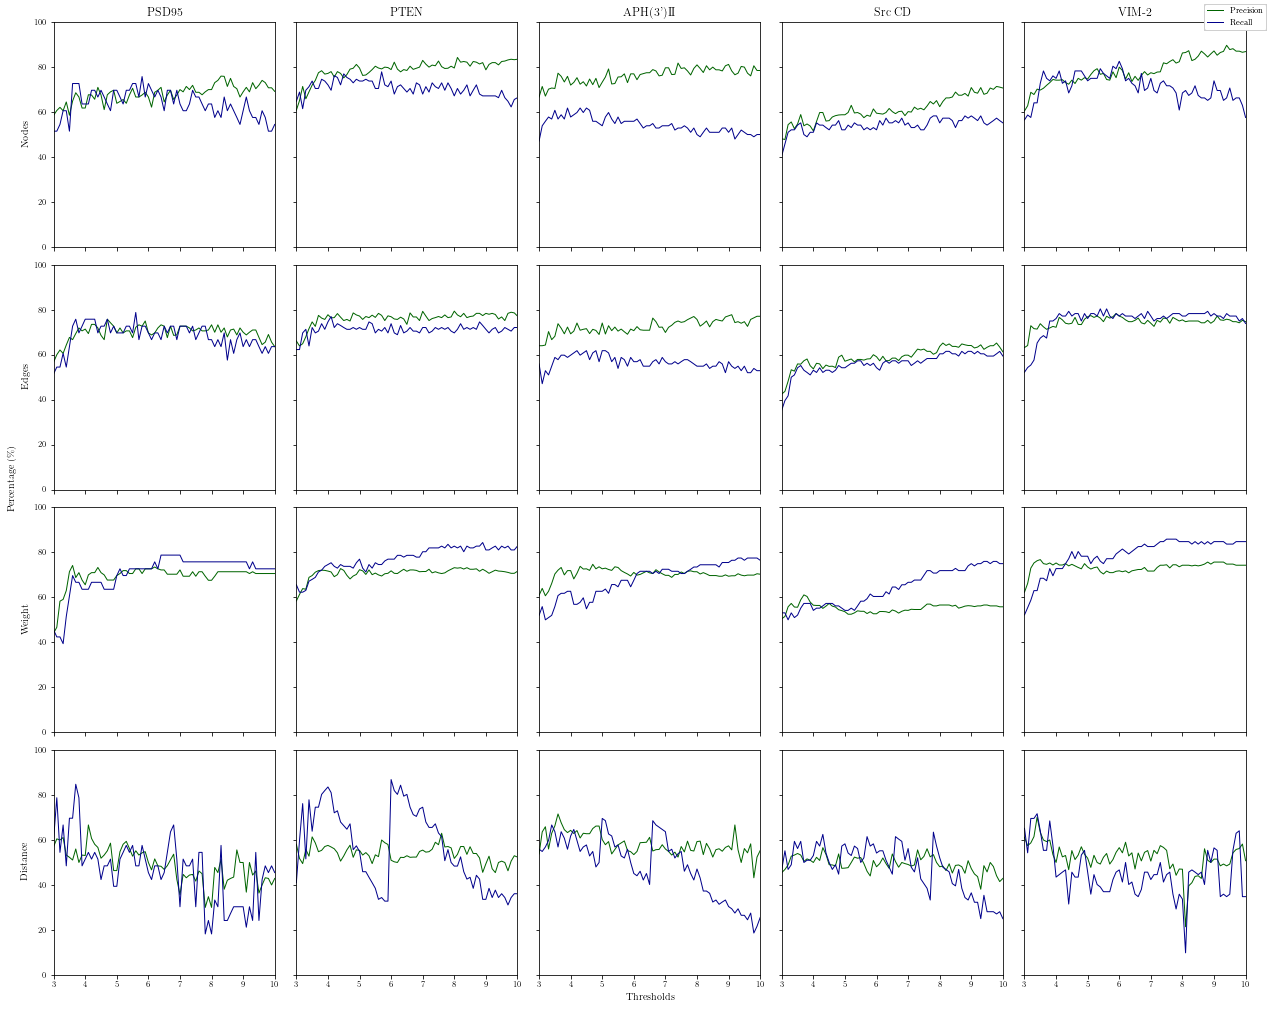

In [31]:
fig = PredictionsOneMeasure(dataOne)
fig.savefig("figures/one_measure.png", dpi=300)

### Comparing perturbation cutoffs with precision and recall scores

In [33]:
def dataCompare(functional_cutoff, network_mincount, thresh=9.0):
    """Obtain data to compare Precision and Recall scores for range of measure cutoffs, considering same cutoff for 
    four measures, ranging from 1 to 2. Considering loss of function predictions."""
    cutoffs = [x for x in np.linspace(1,2,51)]
    
    index = pd.MultiIndex.from_product([proteins, ["Precision", "Recall"]], names=["Protein", "Measure"])
    df = pd.DataFrame(index=index, columns=cutoffs)
    
    for protein in proteins:
        funct_extremes = GetPercentage(functional_cutoff, 'lowest', functional_data[protein])
        for cutoff in cutoffs:
            measure_cutoffs = [cutoff]*4
            network_extremes = GetNetworkExtremes(protein, network_mincount, measure_cutoffs=measure_cutoffs, 
                                                  thresh=thresh)
            how_many = network_extremes.intersection(funct_extremes)
            df.at[(protein, "Precision"), cutoff] = ToPercentage(how_many, network_extremes)
            df.at[(protein, "Recall"), cutoff] = ToPercentage(how_many, funct_extremes)
           
    return df

In [34]:
def ComparePR(df_list):
    """Compare Precision and Recall scores for range of measure cutoffs, returns plot. Based on df resulting 
    from dataCompare, can take 1 or multiple. Input as list of DataFrames. """
    
    n = len(df_list)
        
    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(14,(2.8*n)), sharex=True, sharey=True)
    plt.tight_layout()
    
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.ylabel('Percentage (\%)')
    plt.xlabel('Cutoffs')
    ax = plt.gca()
    ax.xaxis.set_label_coords(0.5, -0.1) if n == 1 else ax.yaxis.set_label_coords(-0.01, 0.5)
    ax.yaxis.set_label_coords(-0.05, 0.5) if n != 1 else ax.yaxis.set_label_coords(-0.03, 0.5)
    
    cutoffs = [x for x in np.linspace(1,2,51)]
    
    for j, df in enumerate(df_list):
        for i, protein in enumerate(proteins):
            precision, recall = [], []
            precision = df.loc[(protein, "Precision"), :].values.tolist()
            recall = df.loc[(protein, "Recall"), :].values.tolist()

            ax = axes[j,i] if n != 1 else axes[i]
            ax.set_xlim(1,2)
            ax.set_ylim(0,100)

            ax.plot(cutoffs, precision, color='darkgreen', markeredgewidth=0.0, linewidth=1, label='Precision')
            ax.plot(cutoffs, recall, color='darkblue', markeredgewidth=0.0, linewidth=1, label='Recall')
            
            #ax.set_aspect(1./ax.get_data_ratio())
            
            if j == 0:
                ax.set_title(protein_names[i])
            if i == 0 and n != 1:
                ax.set_ylabel(f"Min. count = {j+1}")
    
    handles, labels = ax.get_legend_handles_labels()       
    fig.legend(handles, labels)
        
    return fig

In [35]:
compare1 = dataCompare(0.4,1)
compare2 = dataCompare(0.4,2)
compare3 = dataCompare(0.4,3)
compare4 = dataCompare(0.4,4)

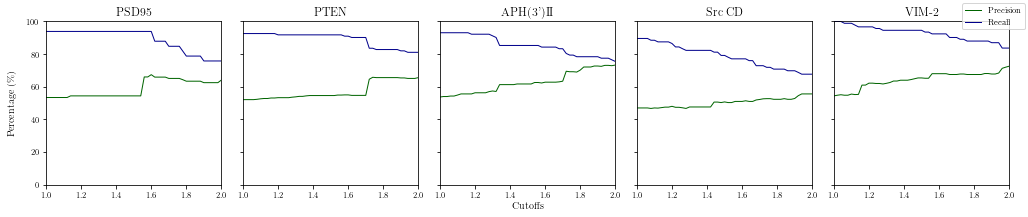

In [36]:
compare1_fig = ComparePR([compare1])
compare1_fig.savefig("figures/compare_pr_min1.png", dpi=300)

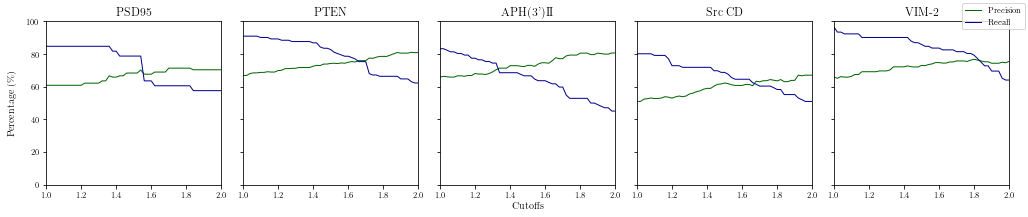

In [37]:
compare2_fig = ComparePR([compare2])
compare2_fig.savefig("figures/compare_pr.png", dpi=300)

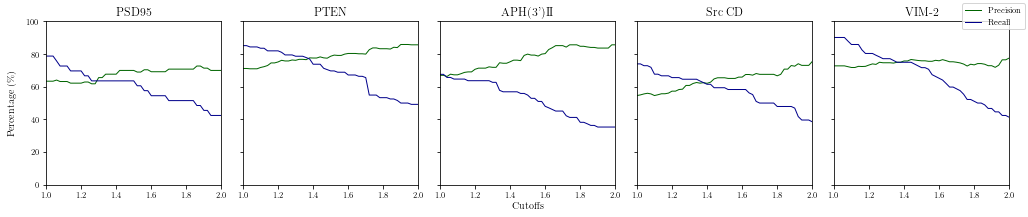

In [38]:
compare3_fig = ComparePR([compare3])
compare3_fig.savefig("figures/compare_pr_min3.png", dpi=300)

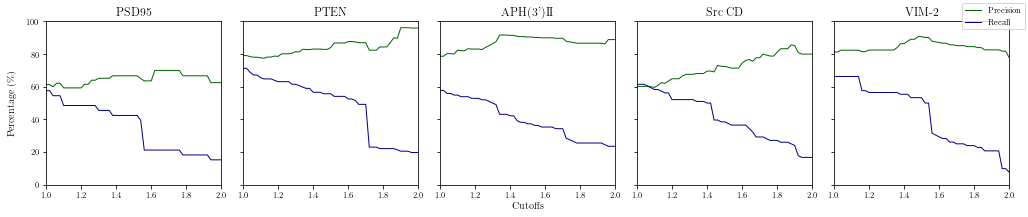

In [39]:
compare4_fig = ComparePR([compare4])
compare4_fig.savefig("figures/compare_pr_min4.png", dpi=300)

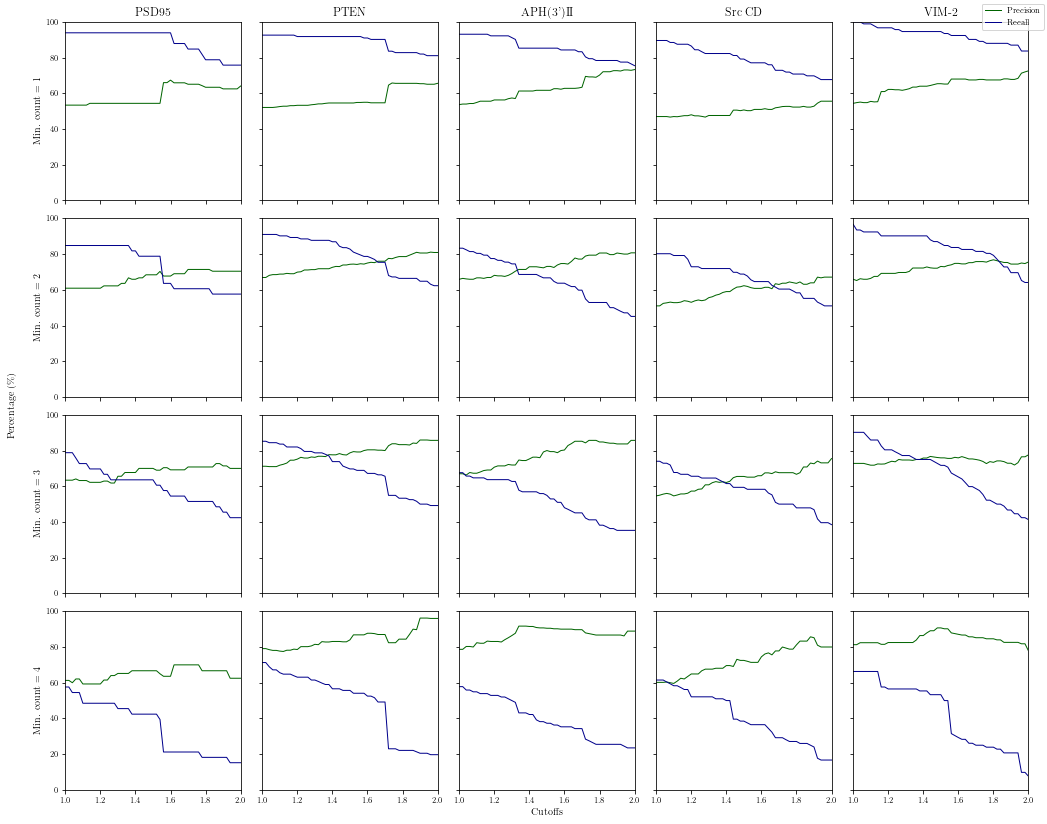

In [40]:
compare_all = ComparePR([compare1, compare2, compare3, compare4])
compare_all.savefig("figures/compare_pr_all.png", dpi=300, bbox_inches='tight')

In [41]:
### Comparing scores across different minimum counts
## mean contains mean over cutoffs, for each protein, measure and min count
index = pd.MultiIndex.from_product([proteins, ["Precision", "Recall"]], names=["Protein", "Measure"])
mean = pd.DataFrame(index=index, columns=[1,2,3,4])

for i,data in enumerate([compare1, compare2, compare3, compare4]):
    mean[i+1] = data.mean(axis=1)

In [42]:
mean

1          2          3          4
Protein Measure                                              
1be9    Precision  58.774510  66.596078  67.715686  64.850980
        Recall     88.868627  72.592157  59.760784  34.586275
1d5r    Precision  57.249020  74.154902  78.790196  84.480392
        Recall     88.988235  79.523529  68.970588  48.286275
1nd4    Precision  62.707843  73.441176  77.550980  86.927451
        Recall     85.425490  65.374510  52.037255  39.482353
3dqw    Precision  50.113725  59.460784  64.082353  71.945098
        Recall     78.696078  66.956863  57.945098  40.386275
4bz3    Precision  64.272549  72.231373  74.417647  84.386275
        Recall     92.754902  84.158824  67.858824  42.284314

In [43]:
## Mean precision for each min count
mean[mean.index.get_level_values("Measure").isin(['Precision'])].mean()

1    58.623529
2    69.176863
3    72.511373
4    78.518039
dtype: float64

In [44]:
## Mean recall for each min count
mean[mean.index.get_level_values("Measure").isin(['Recall'])].mean()

1    86.946667
2    73.721176
3    61.314510
4    41.005098
dtype: float64

In [45]:
compare4[compare4.index.get_level_values("Measure").isin(["Recall"])]

,,1.00,1.02,1.04,1.06,1.08,1.10,1.12,1.14,1.16,1.18,1.20,1.22,1.24,1.26,1.28,1.30,1.32,1.34,1.36,1.38,1.40,1.42,1.44,1.46,1.48,1.50,1.52,1.54,1.56,1.58,1.60,1.62,1.64,1.66,1.68,1.70,1.72,1.74,1.76,1.78,1.80,1.82,1.84,1.86,1.88,1.90,1.92,1.94,1.96,1.98,2.00
Protein,Measure,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1be9,Recall,57.6,57.6,54.5,54.5,54.5,48.5,48.5,48.5,48.5,48.5,48.5,48.5,48.5,48.5,48.5,45.5,45.5,45.5,45.5,42.4,42.4,42.4,42.4,42.4,42.4,42.4,42.4,39.4,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.2,21.2,18.2,18.2,18.2,18.2,18.2,18.2,18.2,18.2,15.2,15.2,15.2,15.2
1d5r,Recall,71.3,71.3,68.9,67.2,67.2,65.6,64.8,64.8,64.8,63.9,63.1,63.1,63.1,63.1,61.5,61.5,60.7,59.8,59.0,59.0,56.6,56.6,56.6,55.7,55.7,55.7,54.1,54.1,54.1,54.1,52.5,52.5,51.6,49.2,49.2,49.2,23.0,23.0,23.0,22.1,22.1,22.1,22.1,22.1,21.3,20.5,20.5,20.5,19.7,19.7,19.7
1nd4,Recall,57.8,57.8,55.9,55.9,54.9,54.9,53.9,53.9,53.9,52.9,52.9,52.9,52.0,52.0,51.0,50.0,49.0,43.1,43.1,43.1,42.2,42.2,39.2,38.2,38.2,37.3,37.3,36.3,36.3,35.3,35.3,35.3,35.3,34.3,34.3,34.3,28.4,27.5,26.5,25.5,25.5,25.5,25.5,25.5,25.5,25.5,25.5,24.5,23.5,23.5,23.5
3dqw,Recall,61.5,61.5,61.5,60.4,59.4,58.3,58.3,57.3,56.2,56.2,52.1,52.1,52.1,52.1,52.1,52.1,52.1,51.0,51.0,51.0,50.0,50.0,39.6,39.6,38.5,38.5,37.5,36.5,36.5,36.5,36.5,36.5,34.4,32.3,29.2,29.2,29.2,28.1,27.1,27.1,27.1,26.0,26.0,26.0,25.0,24.0,17.7,16.7,16.7,16.7,16.7
4bz3,Recall,66.3,66.3,66.3,66.3,66.3,66.3,66.3,66.3,57.6,57.6,56.5,56.5,56.5,56.5,56.5,56.5,56.5,56.5,56.5,55.4,55.4,55.4,53.3,53.3,53.3,53.3,50.0,50.0,31.5,30.4,29.3,28.3,28.3,26.1,26.1,25.0,25.0,25.0,23.9,23.9,23.9,22.8,22.8,20.7,20.7,20.7,20.7,20.7,9.8,9.8,7.6
